In [1]:
%matplotlib inline
from IPython import display
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"


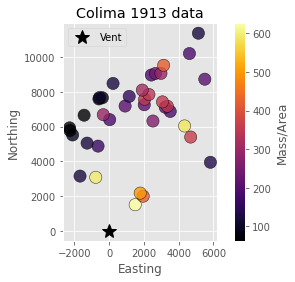

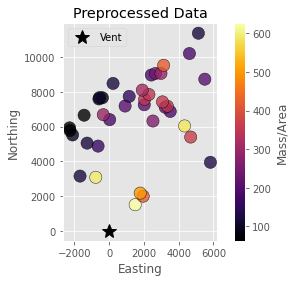

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display.display(raw_df.head())

vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17, 37, 31])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)
obs_df = obs_df.sort_values(by=['radius'])

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [3]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

display.display(config)
display.display(globs)



{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5.0,
 'MIN_GRAINSIZE': 4.0,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

In [4]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

del theo_phi_steps[-1]
del theo_phi_steps[-1]


display.display(pd.DataFrame(theo_phi_steps))


,lower,upper,interval,centroid,density,probability
0,-5,-4,"[-5,-4)",-4.5,"1,024",0.0683375
1,-4,-3,"[-4,-3)",-3.5,"1,024",0.109203
2,-3,-2,"[-3,-2)",-2.5,"1,024",0.146694
3,-2,-1,"[-2,-1)",-1.5,"1,024",0.16565
4,-1,0,"[-1,0)",-0.5,"1,024",0.157243
5,0,1,"[0,1)",0.5,"1,233.5",0.125474
6,1,2,"[1,2)",1.5,"1,443",0.0841661


/home/nice/repos/inversion_project/vis_utils.py:135: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  bg = ax.scatter(
/home/nice/repos/inversion_project/vis_utils.py:135: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  bg = ax.scatter(
/home/nice/repos/inversion_project/vis_utils.py:135: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  bg = ax.scatter(
/home/nice/repos/inversion_project/vis_utils.py:135: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simult

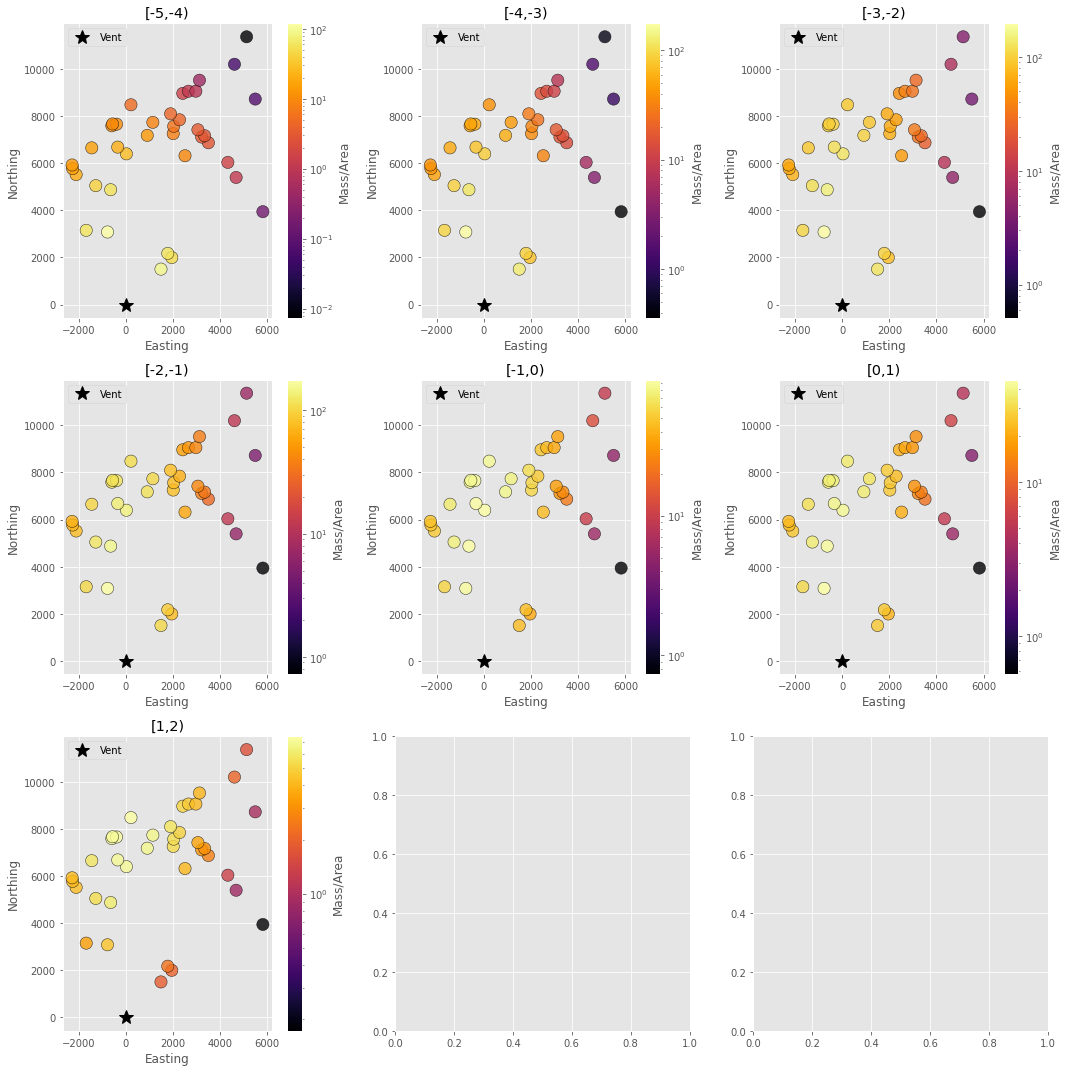

Int64Index([16, 18, 17, 37, 31, 36, 35, 34, 33, 32,  6, 28, 11, 30, 20, 21,  7,
            22, 12, 29, 14,  5, 24, 23,  4, 19, 26, 25, 27,  1, 13,  8,  3, 15,
             0,  2,  9, 10],
           dtype='int64')


In [5]:
sep_phis = []

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, phi in enumerate(theo_phi_steps):
    df, _, _, _ = io.read_tephra2("data/colima/colima_gs_trial/colima_%d_out.txt"%i)
    sep_phis += [df]
    vis.plot_sample(sep_phis[i], vent=(0,0), ax=axs[i], 
                    title="%s"%phi["interval"], cbar_label="Mass/Area")
plt.tight_layout()
plt.show()

print(obs_df.index)

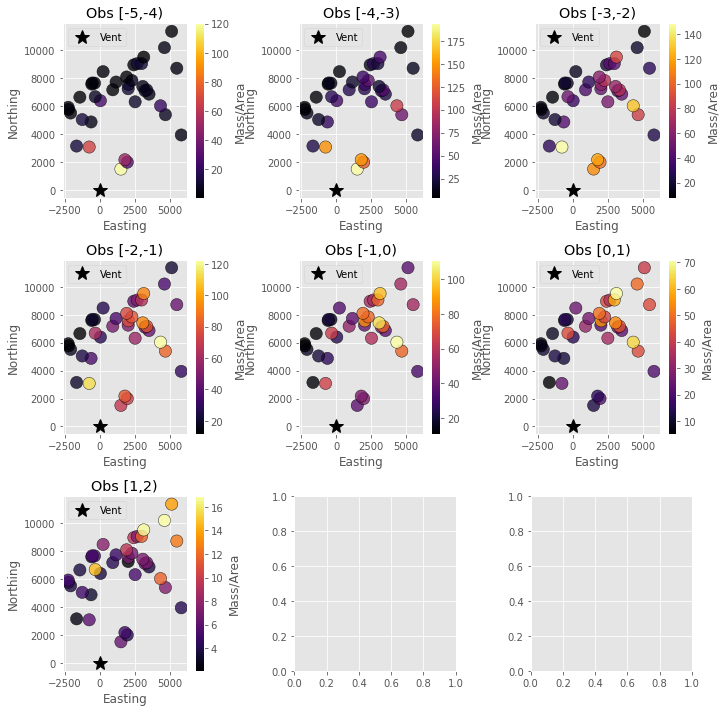

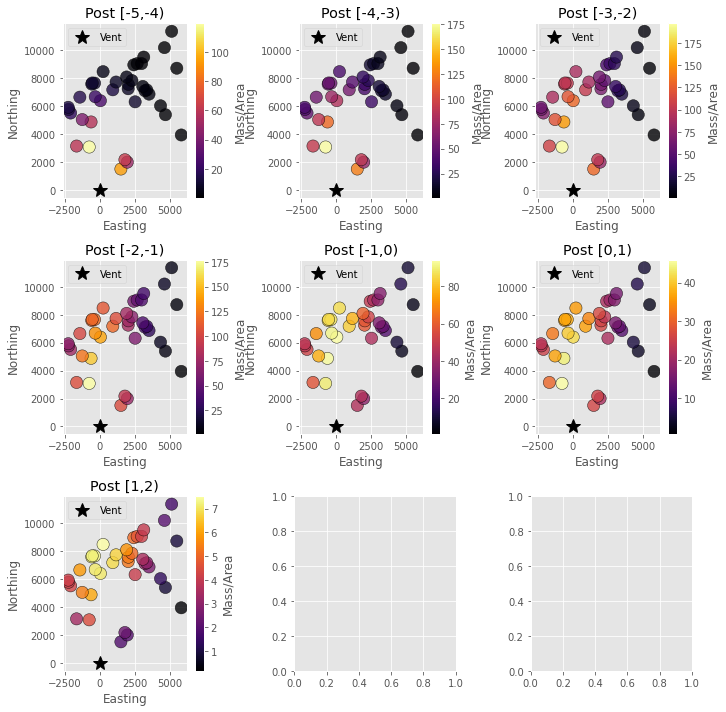

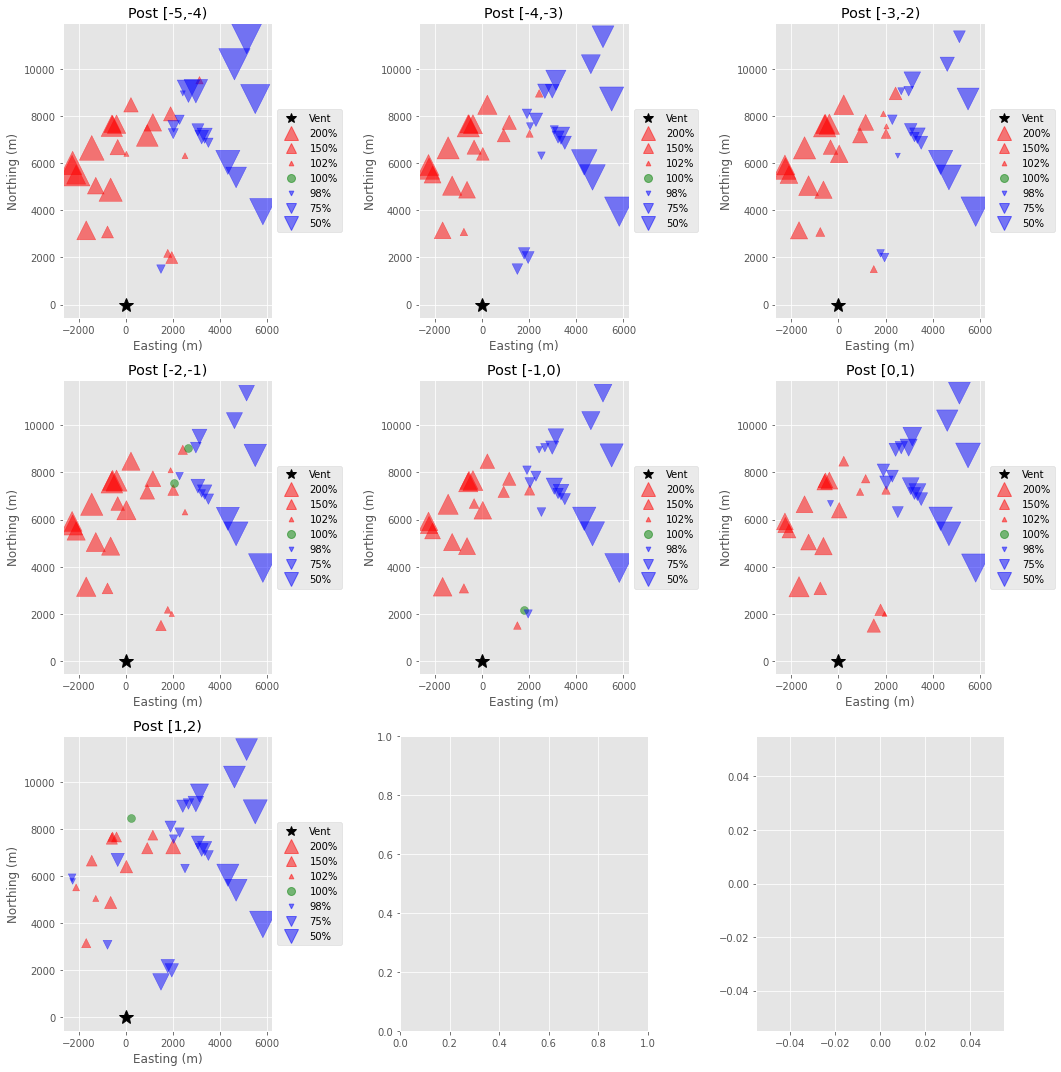

In [16]:
observation_phis = []
posterior_phis = []

prior_phi_steps = theo_phi_steps.copy()

for j, phi_step in enumerate(theo_phi_steps):
    phi_obs = obs_df.copy()
    phi_obs["MassArea"] = phi_obs["MassArea"]*phi_obs[phi_step["interval"]]/100
    phi_obs[phi_step["interval"]] = 100
    bounds=(0, 200)

    observation_phis += [phi_obs]

    phi_post = sep_phis[j].copy()
    phi_post["radius"] = np.sqrt(phi_post["Easting"]**2 + phi_post["Northing"]**2)
    phi_post = phi_post.sort_values(by=['radius'])
    phi_post["Residual"] = phi_post["MassArea"].values/phi_obs["MassArea"].values
    
    posterior_phis += [phi_post]

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Obs %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(posterior_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Post %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_residuals(posterior_phis[j], vent=(0,0), plot_type="size",
                   title="Post %s"%phi_step["interval"], ax=axs[j])
    
plt.tight_layout()
plt.show()

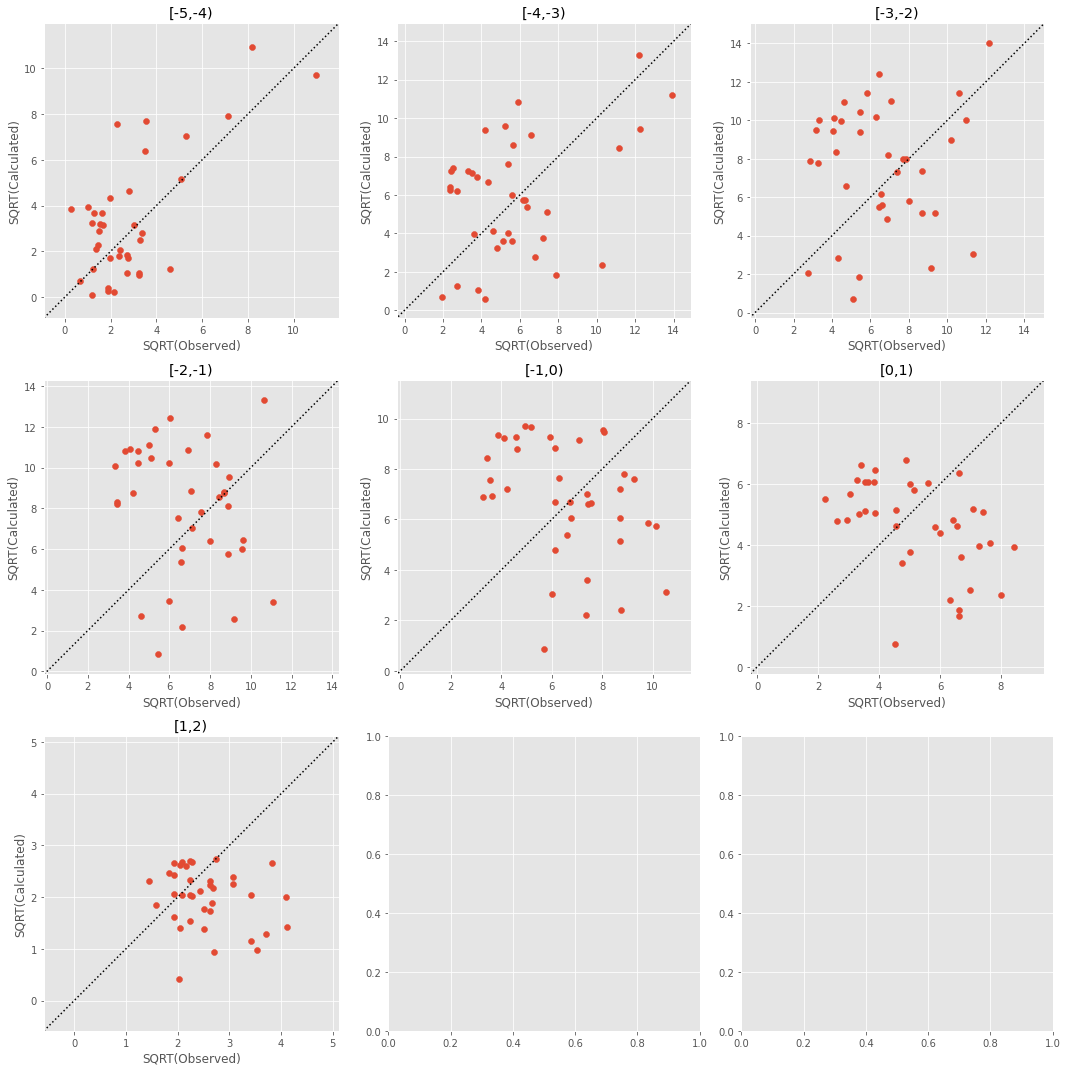

In [15]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    min_mass = min((min(observation_phis[j]["MassArea"].values), min(posterior_phis[j]["MassArea"].values)))
    max_mass = max((max(observation_phis[j]["MassArea"].values), max(posterior_phis[j]["MassArea"].values)))
    axs[j].scatter(np.sqrt(observation_phis[j]["MassArea"].values), np.sqrt(posterior_phis[j]["MassArea"].values))
    axs[j].plot([-100,100],[-100,100], "k:")
    axs[j].set_xlabel("SQRT(Observed)")
    axs[j].set_ylabel("SQRT(Calculated)")
    axs[j].set_aspect('equal', 'box')
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    axs[j].set_ylim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    
plt.tight_layout()
plt.show()

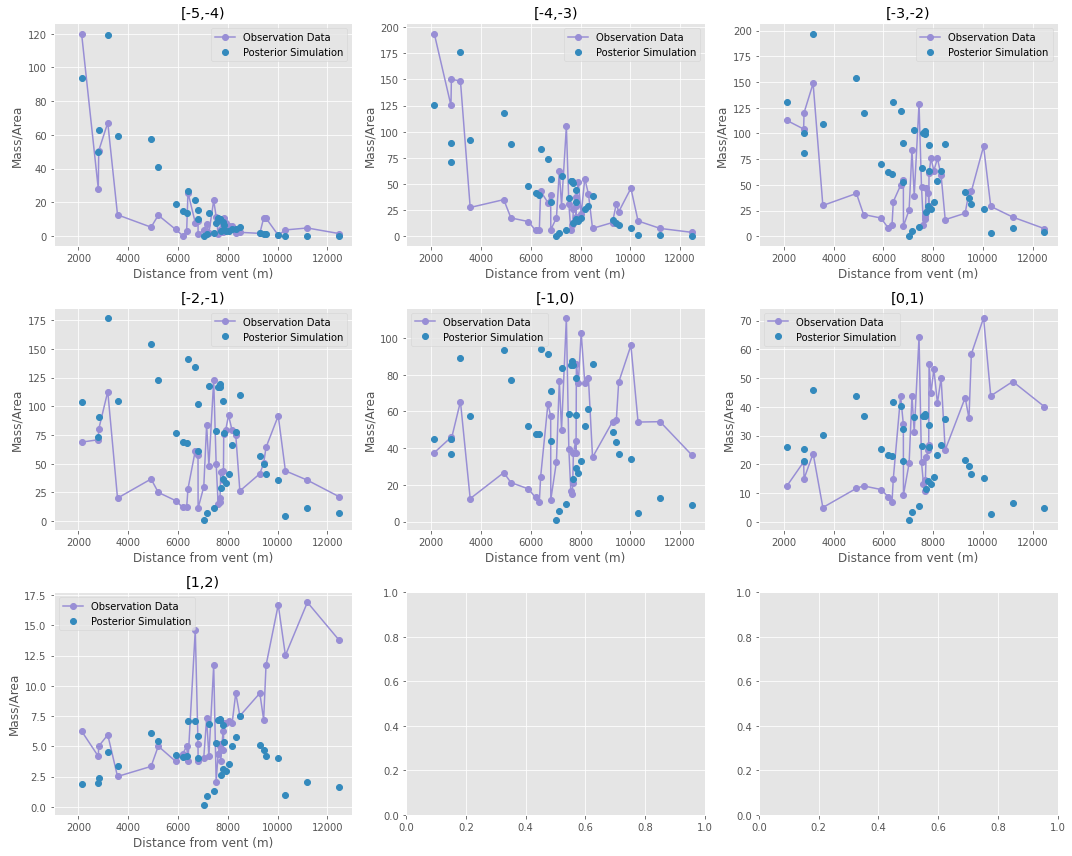

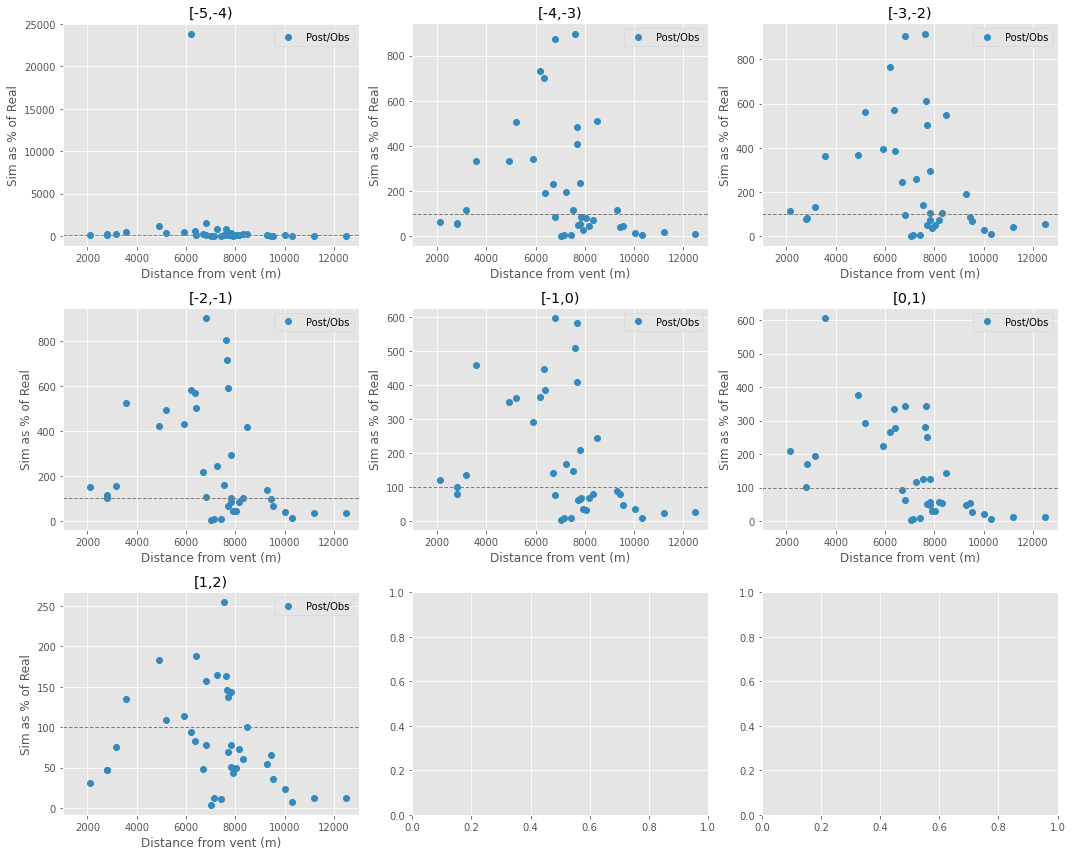

In [8]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"].values, observation_phis[j]["MassArea"].values, 'C2o-', label="Observation Data")
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[j].legend()
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_ylabel("Mass/Area")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[j].axhline(100, linestyle="--", lw=1, c="gray")  
    axs[j].legend()
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_ylabel("Sim as % of Real")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

In [9]:
def misfit_sse(observed, expected):
    return ((observed - expected)**2)/expected

contributions = np.zeros((len(prior_phi_steps), len(observation_phis[0])))
RMSE_contributions = np.zeros((len(prior_phi_steps), len(observation_phis[0])))
print(contributions.shape)
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["MassArea"].values
    for i in range(len(posterior_phis[j])):
        observed = observation_phis[j]["MassArea"].values[i]
        expected = posterior_phis[j]["MassArea"].values[i]
        misfit = ((observed - expected)**2)/expected
        RMSE = ((observed - expected)**2)
        contributions[j,i] = misfit
        RMSE_contributions[j,i] = RMSE
    
RMSE_point_contributions = np.sqrt(np.sum(RMSE_contributions, 0)/38)
RMSE_phi_contributions = np.sqrt(np.sum(RMSE_contributions, 1)/9)

point_contributions = np.sum(contributions, 0)
phi_contributions = np.sum(contributions, 1)

total_misfit = np.sum(np.sum(contributions))

total_RMSE = np.sqrt(np.sum(np.sum(RMSE_contributions))/38)

total_NRMSE = total_RMSE/(np.max(obs_df["MassArea"].values) - np.min(obs_df["MassArea"].values))
display.display(phi_contributions)
print(total_misfit)
print(total_RMSE)
print(total_NRMSE)

(7, 38)


array([1597.45807959, 4841.83972701, 5376.49316601, 4812.28968215,
       5008.18558655, 3724.28352949,  662.99613227])

26023.545903062746
110.10962819183048
0.19550020985020153


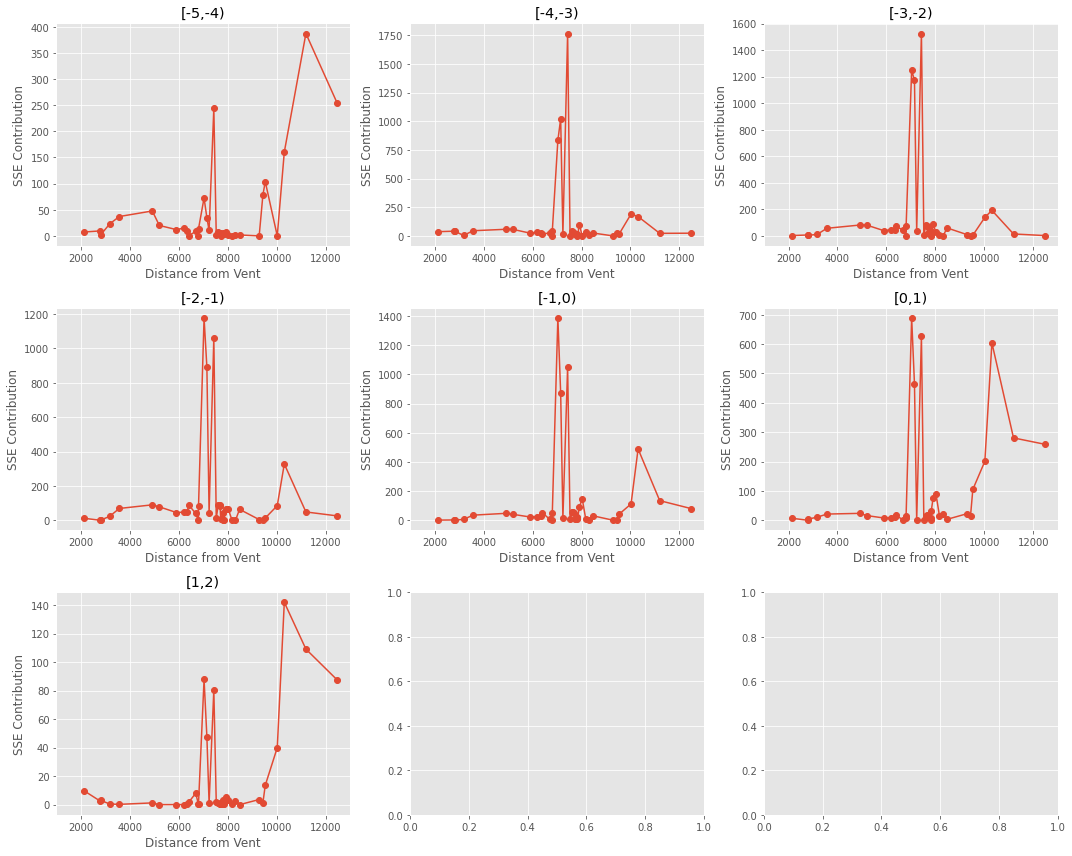

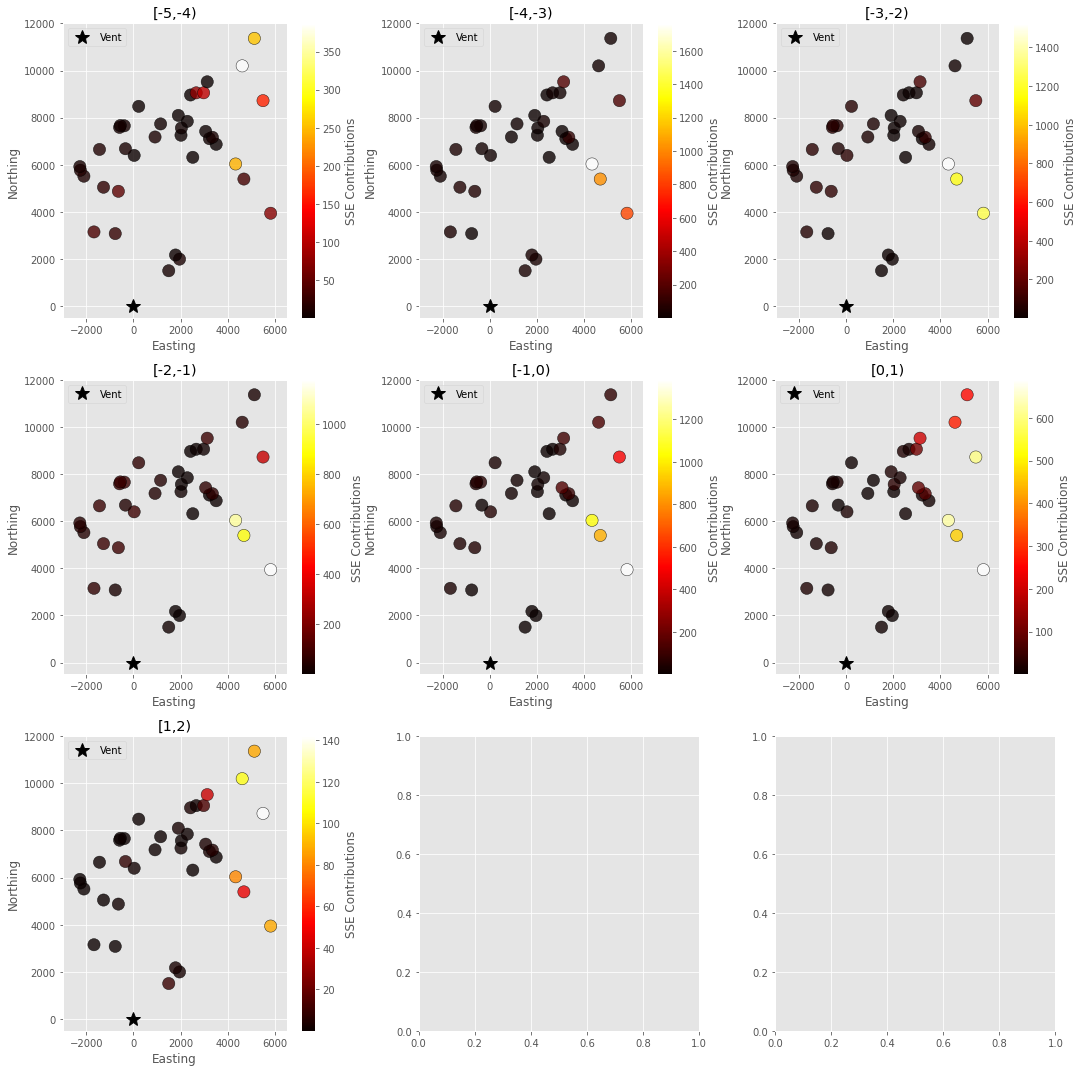

In [10]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"], contributions[j,:], "C0o-")
    axs[j].set_xlabel("Distance from Vent")
    axs[j].set_ylabel("SSE Contribution")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim(1000, 13000)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["Contributions"] = contributions[j,:]
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False, values="Contributions",
                title="SSE Contributions", cbar_label="SSE Contributions", ax = axs[j], cmap="hot")
    axs[j].set_xlim([-3000, 6500])
    axs[j].set_ylim([-500, 12000])
    axs[j].set_title(phi_step["interval"])

plt.tight_layout()
plt.show()

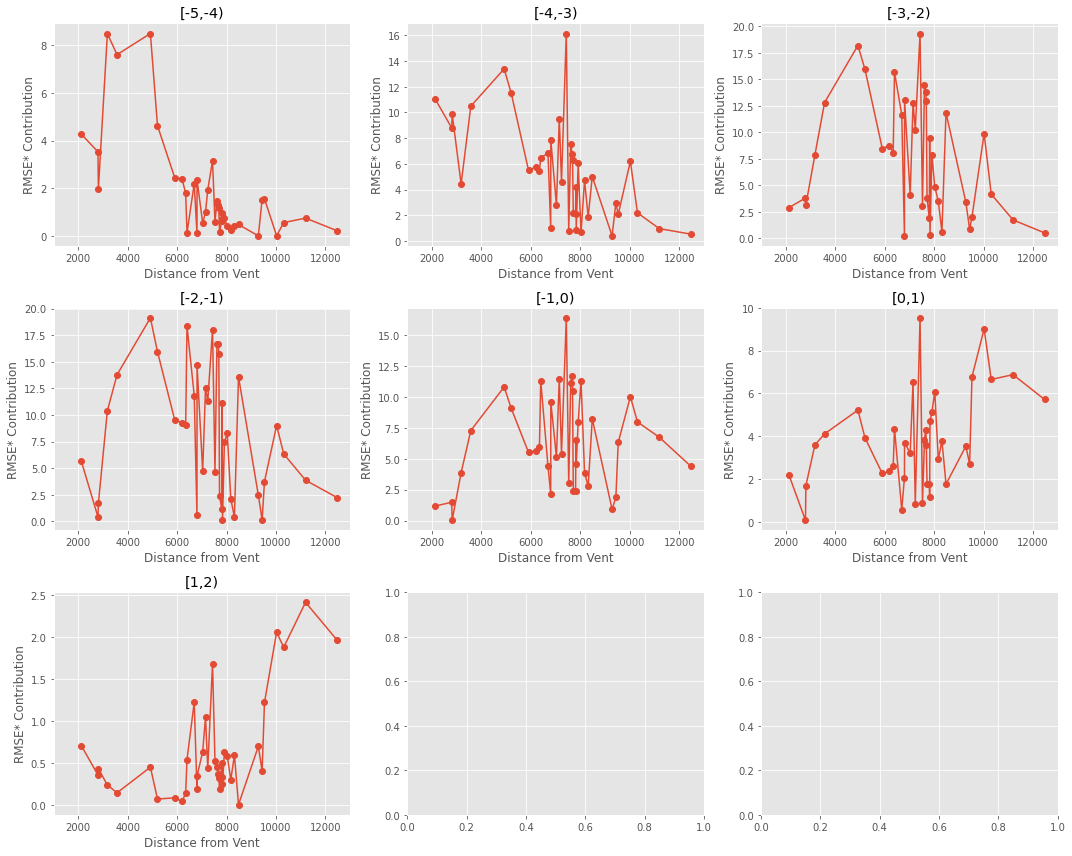

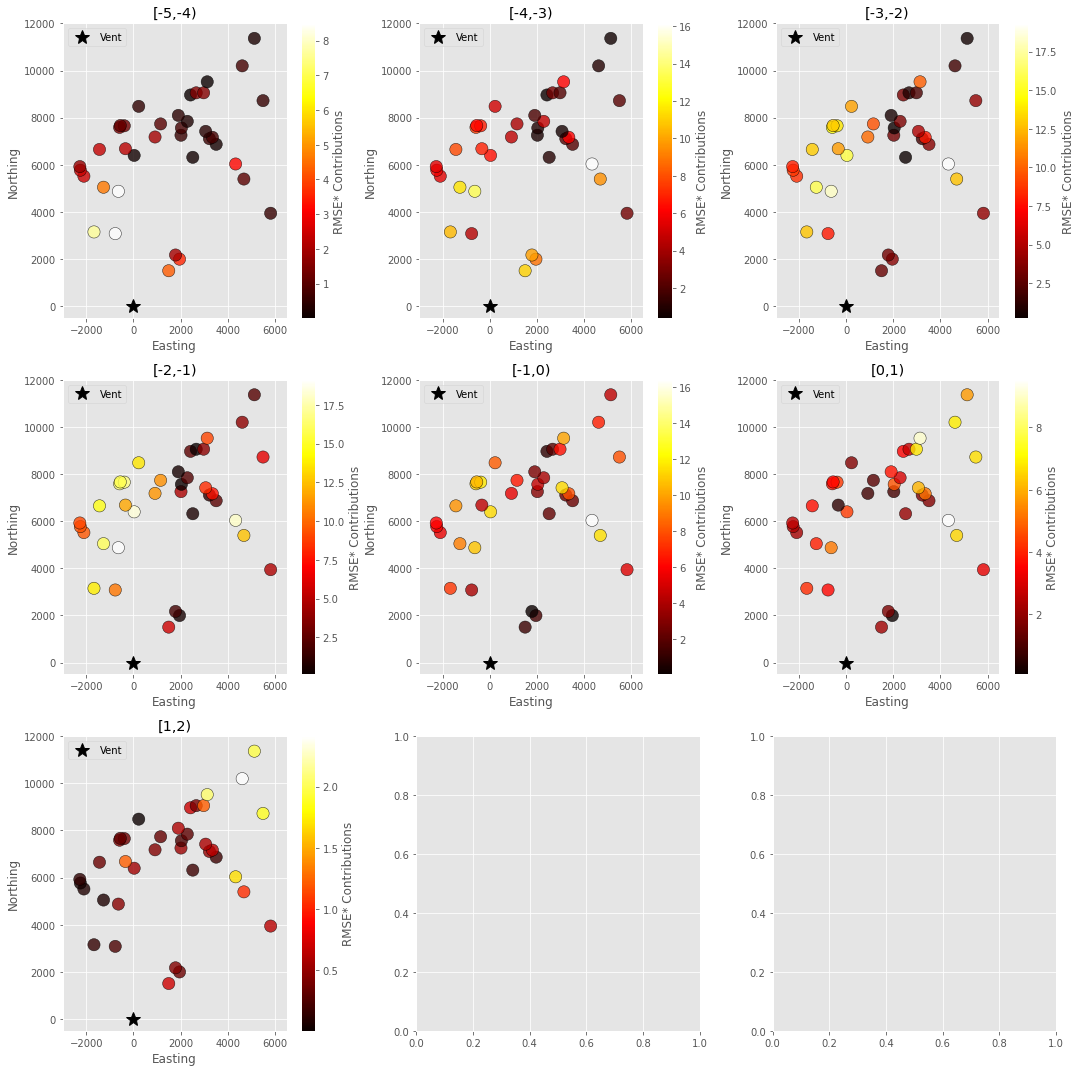

In [11]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"], np.sqrt(RMSE_contributions[j,:]/len(observation_phis[j])), "C0o-")
    axs[j].set_xlabel("Distance from Vent")
    axs[j].set_ylabel("RMSE* Contribution")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim(1000, 13000)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["Contributions"] = np.sqrt(RMSE_contributions[j,:]/len(observation_phis[j]))
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False, values="Contributions", cbar_label="RMSE* Contributions", ax = axs[j], cmap="hot")
    axs[j].set_xlim([-3000, 6500])
    axs[j].set_ylim([-500, 12000])
    axs[j].set_title(phi_step["interval"])A

plt.tight_layout()
plt.show()

In [12]:
row_labels = [phi["interval"] for phi in prior_phi_steps]

num_phis = len(theo_phi_steps)

cont_df = pd.DataFrame(data=contributions.T, columns=row_labels, index = obs_df.index)

min_phis = np.array([min(observation_phis[i]["MassArea"].values) for i in range(num_phis)])
print(min_phis)
max_phis = np.array([max(observation_phis[i]["MassArea"].values) for i in range(num_phis)])
print(max_phis)

#Total sum per column: 
cont_df.loc['Phi Total (RMSE)',:9]= np.sqrt(cont_df.sum(axis=0)/num_phis)
cont_df.loc['Phi Total (NRMSE)',:9] = np.sqrt(cont_df.sum(axis=0)/num_phis)/(max_phis-min_phis)

#Total sum per row: 
cont_df.loc[:38,'Point Total (RMSE*)'] = np.sqrt(cont_df.sum(axis=1)/38)
# cont_df.loc[:,'Point Total (NRMSE)'] = np.sqrt(cont_df.sum(axis=1)/38)

display.display(cont_df)

[ 0.06258  3.7548   7.5096  11.2644  10.6386   5.0064   2.086  ]
[120.1536 193.998  148.6275 122.6568 110.9752  70.924   16.8966]


<ipython-input-12-f5fb2c3d64d3>:13: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  cont_df.loc['Phi Total (RMSE)',:9]= np.sqrt(cont_df.sum(axis=0)/num_phis)
<ipython-input-12-f5fb2c3d64d3>:14: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  cont_df.loc['Phi Total (NRMSE)',:9] = np.sqrt(cont_df.sum(axis=0)/num_phis)/(max_phis-min_phis)
<ipython-input-12-f5fb2c3d64d3>:17: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  cont_df.loc[:38,'Point Total (RMSE*)'] = np.sqrt(cont_df.sum(axis=1)/38)


,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)",Point Total (RMSE*)
16,7.38017,36.8706,2.45085,11.6998,1.17371,7.05083,9.79328,1.41811
18,9.54745,41.4847,6.85211,0.0928271,2.26787,0.0101568,2.43742,1.28445
17,2.37282,41.6146,3.81087,1.21469,0.000409317,4.28541,3.01789,1.21738
37,22.9189,4.27291,11.9212,23.2305,6.40288,10.6748,0.471871,1.44998
31,37.0282,45.3318,57.2382,68.7527,35.1689,21.1767,0.231026,2.64041
36,47.6633,57.9665,81.7993,89.864,47.6602,23.6136,1.25396,3.03411
35,19.9502,56.8148,80.8018,78.3122,40.5965,15.9408,0.0332256,2.77417
34,11.9858,23.9609,39.0009,45.0187,22.3396,7.71511,0.0625387,1.98735
33,14.8162,30.6473,46.9311,47.2788,25.2338,9.0572,0.0157473,2.13973
32,8.89091,28.9402,41.1979,46.1191,28.6418,11.2994,0.17395,2.08543


In [13]:
print(cont_df.loc['Phi Total (NRMSE)'][:9])

print(sum(cont_df.loc['Phi Total (NRMSE)'].values[:9]))

[-5,-4)               0.126386
[-4,-3)               0.138619
[-3,-2)               0.196895
[-2,-1)               0.236021
[-1,0)                0.267294
[0,1)                 0.351004
[1,2)                 0.661909
Point Total (RMSE*)        NaN
Name: Phi Total (NRMSE), dtype: float64
nan


In [14]:
disp_cols = ["Easting",
            "Northing",
            "MassArea",
            "radius"]

display.display(observation_phis[-1][disp_cols].head())

display.display(posterior_phis[-1][disp_cols].head())

display.display(obs_df.head())

,Easting,Northing,MassArea,radius
16,1499,1506,6.258,"2,124.86"
18,1957,1997,4.172,"2,796.04"
17,1787,2173,5.0064,"2,813.41"
37,-770,3082,5.9451,"3,176.73"
31,-1673,3152,2.5032,"3,568.48"


,Easting,Northing,MassArea,radius
16,1499,1506,1.92082,"2,124.86"
18,1957,1997,1.97689,"2,796.04"
17,1787,2173,2.34573,"2,813.41"
37,-770,3082,4.48959,"3,176.73"
31,-1673,3152,3.3879,"3,568.48"


,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86",100
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04",100
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41",100
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73",100
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48",100
